# MCLP
$$Maximize \sum_{i \in I} w_iy_i $$
$$s.t \quad  y_i \leq \sum_{j \in N_i}x_j \quad for \, all \quad i \in I$$
$$ \sum_{j \in J}x_j = K $$
$$x_j,y_i \in {0,1} \quad for \, all \quad i \in I,j \in J$$

|문자|의미|
|-|-|
|i|수요 포인트 index|
|j|설비지역 포인트 index|
|I|수요 포인트 집합|
|J|설비지역 포인트 집합|
|K|설치해야하는 설비 개수|
|x|설비 후보 지역 중 위치 j 에 설치되면 1, 아니면 0|
|y|적어도 하나의 설비로 그 포인트가 커버되면 1, 아니면 0|
|w|입지 선정 지수=가중치|

## [공간최적화 참조 코드](https://pysal.org/spaghetti/notebooks/facility-location.html)

# 모듈 불러오기

In [1]:
import os
os.getcwd()
%config InlineBackend.figure_format = "retina"

In [2]:
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력
from IPython.display import HTML #출력 결과를 HTML로 생성

In [3]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline

# 한글폰트
import os
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

import numpy as np
import folium

In [4]:
try:
    from IPython.display import Markdown as md
except ImportError:
    pass

# Define a Class and functions

In [5]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship folowing optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )


In [6]:
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [7]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1,color='dimgray')
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv))
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        #add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [8]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    #add_legend(patches, for_multiplot=True)

In [9]:
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )

In [10]:
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

In [11]:
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches

In [12]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "aqua",
        "crimson",
        "cyan",
        "limegreen",
        "snow",
        "mintcream",
        "lemonchiffon",
        "lightcoral",
        "peachpuff",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "rebeccapurple",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
        'azure',
        'aquamarine',
        'mintcream',    
    ]
    

    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors

In [13]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

## Utilizing libpysal.cg.alpha_shapes

In [14]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv

In [15]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

In [16]:
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    model_names = [m.name for m in mdls]
    boiler = " to assigned facility"
    stats = {
        "abs_min": "Absolute min dist" + boiler,
        "abs_max": "Absolute max dist" + boiler,
        "mean_means": "Mean of mean dists per client" + boiler,
        "mean_stds": "Mean of StD dists per client" + boiler,
    }
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = list(stats.keys())
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(list(stats.keys()))}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.set_caption(stats).background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style

In [17]:
def selection_matrix(mdls):
    """create stylized dataframe visualization of selected decision variables.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame."""
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style


In [18]:
# def add_legend(patches, for_multiplot=False):
#     """
#     Add a legend to a plot
#     Parameters
#     ----------
#     patches : list
#         legend handles matching plotted items
#     for_multiplot : create_patches
#     """
#     if for_multiplot:
#         anchor = (1.1, 1.65)
#     else:
#         anchor = (1.005, 1.016)
#     legend = plt.legend(
#         handles=patches,
#         loc="upper left",
#         fancybox=True,
#         framealpha=0.85,
#         bbox_to_anchor=anchor,
#         fontsize="x-large",
#         labelspacing=1.5,
#         borderpad=2.
#     )
#     legend.get_frame().set_facecolor("white")

# Geopandas Data
## 서울시 shp
- road = 도로 shape파일  
- emd = 읍면동 shape파일  
- sig = 시군구 shape파일

In [19]:
# 도로shp 파일 불러오기
road = geopandas.read_file('dataset\Z_KAIS_TL_SPRD_MANAGE_제주\Z_KAIS_TL_SPRD_MANAGE_50000.shp',encoding = 'ANSI')
#SHP 파일 geometry 좌표변환
road = road.to_crs(epsg=4326)
display(road.head())

,ALWNC_DE,ALWNC_RESN,BSI_INT,ENG_RN,MVMN_DE,MVMN_RESN,MVM_RES_CD,NTFC_DE,OPERT_DE,RBP_CN,...,RDS_MAN_NO,REP_CN,RN,RN_CD,ROAD_BT,ROAD_LT,ROA_CLS_SE,SIG_CD,WDR_RD_CD,geometry
0,20081112,산양 연화동과 저지 명이동간 연결도로 의미부여,20,Yeonmyeong-ro,20190410,도로구간변경,12,20081112,20190410112313,한경면 청수리 3390-0,...,19975,한경면 청수리 3390-0,연명로,3020001,4.000,61.647,3,50110,2,"LINESTRING (126.25420 33.29289, 126.25418 33.2..."
1,20081112,산양 연화동과 저지 명이동간 연결도로 의미부여,20,Yeonmyeong-ro,20141031,직권수정(속성변경),99,20081112,20190715174336,청수리 3329-1대,...,6994,저지리 3139-1대,연명로,3020001,3.000,5694.000,3,50110,2,"LINESTRING (126.26934 33.31728, 126.26941 33.3..."
2,20081112,산양 연화동과 저지 명이동간 연결도로 의미부여,20,Yeonmyeong-ro,20141031,직권수정(속성변경),99,20081112,20190715173923,청수리 3329-1대,...,4696,저지리 3139-1대,연명로,3020001,4.000,5694.000,3,50110,2,"LINESTRING (126.24694 33.28947, 126.24697 33.2..."
3,20081112,산양 연화동과 저지 명이동간 연결도로 의미부여,20,Yeonmyeong-ro,20141031,"광역도로 정비 및 부여사유, 부여방식 정비",90,20081112,20141031015319,청수리 3329-1대,...,11216,저지리 3139-1대,연명로,3020001,3.213,5694.000,3,50110,2,"LINESTRING (126.26134 33.31170, 126.26133 33.3..."
4,20081112,산양 연화동과 저지 명이동간 연결도로 의미부여,20,Yeonmyeong-ro,20141031,직권수정(속성변경),99,20081112,20190715174617,청수리 3329-1대,...,3025,저지리 3139-1대,연명로,3020001,3.000,5694.000,3,50110,2,"LINESTRING (126.24888 33.28993, 126.24886 33.2..."


In [20]:
# 읍면동 시군구 shp 파일 불러오기
emd = geopandas.read_file('dataset\EMD_20220324\emd.shp', encoding = 'euc-kr')
emd = emd.to_crs(epsg=4326)
sig = geopandas.read_file('dataset\SIG_20220324\sig.shp', encoding = 'euc-kr')
sig = sig.to_crs(epsg=4326)
jeju_EMD = emd[emd['EMD_CD'].str.startswith('50')]
jeju_sig = sig[sig['SIG_CD'].str.startswith('50')]

display(jeju_EMD.head())
display(jeju_sig.head())

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
4980,50110101,Ildo 1(il)-dong,일도일동,"POLYGON ((126.52466 33.51591, 126.52471 33.515..."
4981,50110102,Ildo 2(i)-dong,일도이동,"POLYGON ((126.53841 33.51423, 126.54379 33.513..."
4982,50110103,Ido 1(il)-dong,이도일동,"POLYGON ((126.52564 33.51308, 126.52564 33.513..."
4983,50110104,Ido 2(i)-dong,이도이동,"POLYGON ((126.54113 33.50311, 126.54123 33.503..."
4984,50110105,Samdo 1(il)-dong,삼도일동,"POLYGON ((126.51990 33.50437, 126.52190 33.504..."


,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
248,50110,Jeju-si,제주시,"MULTIPOLYGON (((126.15092 33.30877, 126.15090 ..."
249,50130,Seogwipo-si,서귀포시,"MULTIPOLYGON (((126.26745 33.11373, 126.26737 ..."


In [21]:
df_emer = pd.read_csv('dataset\processedData\emergency.csv')
df_hotel = pd.read_csv('dataset\processedData\hotel.csv')
df_school = pd.read_csv('dataset\processedData\school.csv')
df_store = pd.read_csv('dataset\processedData\store.csv')
df_wifi = pd.read_csv('dataset\processedData\wifi.csv')

df_emer = df_emer.drop(['의료기관'], axis=1)
df_emer['type'] = 'emer'

df_hotel = df_hotel.drop(['행정시', '업소명'], axis=1)
df_hotel['type'] = 'hotel'

df_school = df_school.drop(['학교', '자치구', '남녀공학구분'], axis=1)
df_school = df_school.rename(columns={'주소' : '소재지'})
df_school['type'] = 'school'

df_store = df_store.drop(['사업장명'], axis=1)
df_store = df_store.rename(columns={'도로명주소' : '소재지'})
df_store['type'] = 'store'

df_wifi = df_wifi.drop(['user_count', '설치장소', '행정시', '읍면동'], axis=1)
df_wifi = df_wifi.rename(columns={'주소' : '소재지'})
df_wifi['type'] = 'wifi'

In [22]:
df_merge1 = pd.merge(df_emer, df_hotel, how='outer')
df_merge2 = pd.merge(df_merge1, df_school, how='outer')
df_merge3 = pd.merge(df_merge2, df_store, how='outer')
df_merge4 = pd.merge(df_merge3, df_wifi, how='outer')

In [23]:
df_merge4 = df_merge4[['type', '소재지', 'X', 'Y']]
df_merge4 = df_merge4.rename(columns={'X' : '경도', 'Y' : '위도'})

클라이언트들이 법정동 경계 내에 있는지 확인하여 법정동을 매핑하는 과정

In [24]:
jeju_EMD
clients = geopandas.GeoDataFrame(df_merge4, geometry=geopandas.points_from_xy(df_merge4['경도'], df_merge4['위도']))
clients.set_crs(epsg=4326, inplace=True)

f = lambda x: jeju_EMD['geometry'].contains(x)
result = clients['geometry'].apply(f)
jeju_EMD[(result == True).any(axis=0)]

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
4980,50110101,Ildo 1(il)-dong,일도일동,"POLYGON ((126.52466 33.51591, 126.52471 33.515..."
4981,50110102,Ildo 2(i)-dong,일도이동,"POLYGON ((126.53841 33.51423, 126.54379 33.513..."
4982,50110103,Ido 1(il)-dong,이도일동,"POLYGON ((126.52564 33.51308, 126.52564 33.513..."
4983,50110104,Ido 2(i)-dong,이도이동,"POLYGON ((126.54113 33.50311, 126.54123 33.503..."
4984,50110105,Samdo 1(il)-dong,삼도일동,"POLYGON ((126.51990 33.50437, 126.52190 33.504..."
...,...,...,...,...
5049,50130250,Daejeong-eup,대정읍,"MULTIPOLYGON (((126.22448 33.24161, 126.22441 ..."
5050,50130253,Namwon-eup,남원읍,"MULTIPOLYGON (((126.54068 33.36718, 126.54248 ..."
5051,50130259,Seongsan-eup,성산읍,"MULTIPOLYGON (((126.89033 33.48036, 126.89033 ..."
5052,50130310,Andeok-myeon,안덕면,"MULTIPOLYGON (((126.30853 33.22840, 126.30850 ..."


In [25]:
file = geopandas.sjoin(jeju_EMD, clients, how='right', op="contains")
file = file.drop(["EMD_CD", "EMD_ENG_NM", 'index_left'], axis=1)
file.to_csv("dataset/processedData/UMD_clients.csv")
file

,EMD_KOR_NM,type,소재지,경도,위도,geometry
0,연동,emer,제주특별자치도 제주시 도령로 65,126.484920,33.490266,POINT (126.48492 33.49027)
1,아라일동,emer,제주특별자치도 제주시 아란13길 15,126.545201,33.467209,POINT (126.54520 33.46721)
2,이도이동,emer,제주특별자치도 제주시 연신로 52,126.546239,33.496287,POINT (126.54624 33.49629)
3,동홍동,emer,제주특별자치도 서귀포시 장수로 47,126.562949,33.255981,POINT (126.56295 33.25598)
4,이호이동,emer,제주특별자치도 제주시 월랑로 91,126.470481,33.492321,POINT (126.47048 33.49232)
...,...,...,...,...,...,...
3076,화북일동,wifi,제주시 화북일동 11-8,126.573761,33.519675,POINT (126.57376 33.51967)
3077,화북일동,wifi,제주시 화북일동 9-2,126.576347,33.519826,POINT (126.57635 33.51983)
3078,화북일동,wifi,제주시 화북일동 14-1,126.576666,33.517935,POINT (126.57667 33.51794)
3079,회수동,wifi,서귀포시 회수동 788-2,126.442481,33.263100,POINT (126.44248 33.26310)


In [26]:
gong = pd.read_csv('dataset\processedData\pharmacy.csv',encoding = 'utf-8')
gong = geopandas.GeoDataFrame(gong, geometry=geopandas.points_from_xy(gong['X'], gong['Y']))
gong.set_crs(epsg=4326, inplace=True)

file = geopandas.sjoin(jeju_EMD, gong, how='right', op="contains")
file = file.drop(["EMD_CD", "EMD_ENG_NM", 'index_left'], axis=1)
file.to_csv("dataset/processedData/UMD_pharmacy.csv")

In [27]:
file

,EMD_KOR_NM,사업장명,도로명전체주소,X,Y,geometry
0,연동,낙산약국,"제주특별자치도 제주시 도령로 87, 현대오피스텔 1층 106,107호 (연동)",126.487275,33.490869,POINT (126.48728 33.49087)
1,법환동,월드컵약국,"제주특별자치도 서귀포시 일주동로 9213, GS25 1층 6호 (법환동)",126.508491,33.248712,POINT (126.50849 33.24871)
2,삼양이동,삼양약국,"제주특별자치도 제주시 일주동로 366, 1층 (삼양이동)",126.584080,33.520884,POINT (126.58408 33.52088)
3,노형동,천지약국,"제주특별자치도 제주시 1100로 3347, 1층 (노형동)",126.479606,33.484837,POINT (126.47961 33.48484)
4,도남동,해모로약국,"제주특별자치도 제주시 연삼로 305, 101호 (도남동)",126.525167,33.492385,POINT (126.52517 33.49239)
...,...,...,...,...,...,...
286,일도이동,조은약국,제주특별자치도 제주시 동문로20길 1 (일도이동),126.536632,33.513631,POINT (126.53663 33.51363)
287,영평동,써니약국,"제주특별자치도 제주시 첨단로 217, 1층 (영평동)",126.571667,33.452959,POINT (126.57167 33.45296)
288,도남동,단단약국,"제주특별자치도 제주시 서광로 272, 1층 (도남동)",126.525426,33.499787,POINT (126.52543 33.49979)
289,건입동,터미널약국,"제주특별자치도 제주시 임항로 111, 제주항연안여객터미널 1층 (건입동)",126.534226,33.520041,POINT (126.53423 33.52004)


## 서울시 음식점 clients
- 파일 불러오기
- geodf 변환

In [28]:
clients = pd.read_csv('dataset/processedData/UMD_clients.csv', encoding='UTF-8', index_col=0)
display(clients.head())
clients.shape

,EMD_KOR_NM,type,소재지,경도,위도,geometry
0,연동,emer,제주특별자치도 제주시 도령로 65,126.484920,33.490266,POINT (126.484919722369 33.4902661749243)
1,아라일동,emer,제주특별자치도 제주시 아란13길 15,126.545201,33.467209,POINT (126.545201028535 33.4672085209581)
2,이도이동,emer,제주특별자치도 제주시 연신로 52,126.546239,33.496287,POINT (126.546238571767 33.4962868079834)
3,동홍동,emer,제주특별자치도 서귀포시 장수로 47,126.562949,33.255981,POINT (126.562948872895 33.2559809912099)
4,이호이동,emer,제주특별자치도 제주시 월랑로 91,126.470481,33.492321,POINT (126.470480704295 33.4923211704292)


(3081, 6)

In [29]:
#가져온 데이터가 기존에 5179좌표계여서 set_crs만 진행
clients = geopandas.GeoDataFrame(clients, geometry=geopandas.points_from_xy(clients['경도'], clients['위도']))
clients.set_crs(epsg = 4326, inplace = True)
clients.head(2)

,EMD_KOR_NM,type,소재지,경도,위도,geometry
0,연동,emer,제주특별자치도 제주시 도령로 65,126.484920,33.490266,POINT (126.48492 33.49027)
1,아라일동,emer,제주특별자치도 제주시 아란13길 15,126.545201,33.467209,POINT (126.54520 33.46721)


## 공공공지 facility

In [30]:
gong = pd.read_csv('dataset/processedData/UMD_pharmacy.csv',encoding = 'utf-8', index_col=0)
display(gong.head())
gong.shape

,EMD_KOR_NM,사업장명,도로명전체주소,X,Y,geometry
0,연동,낙산약국,"제주특별자치도 제주시 도령로 87, 현대오피스텔 1층 106,107호 (연동)",126.487275,33.490869,POINT (126.487275468846 33.4908688308155)
1,법환동,월드컵약국,"제주특별자치도 서귀포시 일주동로 9213, GS25 1층 6호 (법환동)",126.508491,33.248712,POINT (126.508491059708 33.248712252659)
2,삼양이동,삼양약국,"제주특별자치도 제주시 일주동로 366, 1층 (삼양이동)",126.584080,33.520884,POINT (126.584080157623 33.5208841725461)
3,노형동,천지약국,"제주특별자치도 제주시 1100로 3347, 1층 (노형동)",126.479606,33.484837,POINT (126.479605628771 33.4848372184625)
4,도남동,해모로약국,"제주특별자치도 제주시 연삼로 305, 101호 (도남동)",126.525167,33.492385,POINT (126.525167130007 33.4923853689194)


(291, 6)

In [31]:
#가져온 데이터가 기존에 5179좌표계여서 set_crs만 진행
gong = geopandas.GeoDataFrame(gong, geometry=geopandas.points_from_xy(gong['X'], gong['Y']))
gong.set_crs(epsg = 4326, inplace = True)
gong.head(2)

,EMD_KOR_NM,사업장명,도로명전체주소,X,Y,geometry
0,연동,낙산약국,"제주특별자치도 제주시 도령로 87, 현대오피스텔 1층 106,107호 (연동)",126.487275,33.490869,POINT (126.48728 33.49087)
1,법환동,월드컵약국,"제주특별자치도 서귀포시 일주동로 9213, GS25 1층 6호 (법환동)",126.508491,33.248712,POINT (126.50849 33.24871)


# 입지모델 
## 강남구

### 구 추출
- 행정구 코드 베이스로 추출 진행

In [32]:
gangnam_streets = road[road['SIG_CD'].str.startswith('501')]

In [33]:
gangnam_clients = clients
gangnam_clients.shape

(3081, 6)

In [34]:
gangnam_clients

,EMD_KOR_NM,type,소재지,경도,위도,geometry
0,연동,emer,제주특별자치도 제주시 도령로 65,126.484920,33.490266,POINT (126.48492 33.49027)
1,아라일동,emer,제주특별자치도 제주시 아란13길 15,126.545201,33.467209,POINT (126.54520 33.46721)
2,이도이동,emer,제주특별자치도 제주시 연신로 52,126.546239,33.496287,POINT (126.54624 33.49629)
3,동홍동,emer,제주특별자치도 서귀포시 장수로 47,126.562949,33.255981,POINT (126.56295 33.25598)
4,이호이동,emer,제주특별자치도 제주시 월랑로 91,126.470481,33.492321,POINT (126.47048 33.49232)
...,...,...,...,...,...,...
3076,화북일동,wifi,제주시 화북일동 11-8,126.573761,33.519675,POINT (126.57376 33.51967)
3077,화북일동,wifi,제주시 화북일동 9-2,126.576347,33.519826,POINT (126.57635 33.51983)
3078,화북일동,wifi,제주시 화북일동 14-1,126.576666,33.517935,POINT (126.57667 33.51794)
3079,회수동,wifi,서귀포시 회수동 788-2,126.442481,33.263100,POINT (126.44248 33.26310)


In [35]:
gangnam_facility = gong
gangnam_facility

,EMD_KOR_NM,사업장명,도로명전체주소,X,Y,geometry
0,연동,낙산약국,"제주특별자치도 제주시 도령로 87, 현대오피스텔 1층 106,107호 (연동)",126.487275,33.490869,POINT (126.48728 33.49087)
1,법환동,월드컵약국,"제주특별자치도 서귀포시 일주동로 9213, GS25 1층 6호 (법환동)",126.508491,33.248712,POINT (126.50849 33.24871)
2,삼양이동,삼양약국,"제주특별자치도 제주시 일주동로 366, 1층 (삼양이동)",126.584080,33.520884,POINT (126.58408 33.52088)
3,노형동,천지약국,"제주특별자치도 제주시 1100로 3347, 1층 (노형동)",126.479606,33.484837,POINT (126.47961 33.48484)
4,도남동,해모로약국,"제주특별자치도 제주시 연삼로 305, 101호 (도남동)",126.525167,33.492385,POINT (126.52517 33.49239)
...,...,...,...,...,...,...
286,일도이동,조은약국,제주특별자치도 제주시 동문로20길 1 (일도이동),126.536632,33.513631,POINT (126.53663 33.51363)
287,영평동,써니약국,"제주특별자치도 제주시 첨단로 217, 1층 (영평동)",126.571667,33.452959,POINT (126.57167 33.45296)
288,도남동,단단약국,"제주특별자치도 제주시 서광로 272, 1층 (도남동)",126.525426,33.499787,POINT (126.52543 33.49979)
289,건입동,터미널약국,"제주특별자치도 제주시 임항로 111, 제주항연안여객터미널 1층 (건입동)",126.534226,33.520041,POINT (126.53423 33.52004)


섬 밖의 제주도로 포함되는 지역 삭제

In [36]:
index1 = gangnam_clients[gangnam_clients['위도'] >= 33.6].index
index2 = gangnam_facility[gangnam_facility['Y'] >= 33.6].index
gangnam_clients = gangnam_clients.drop(index1)
gangnam_facility = gangnam_facility.drop(index2)

In [37]:
ycoords = gangnam_streets['geometry'][0].xy[1]
ycoords[0]

index3 = []
for i in range(len(gangnam_streets)):
    for j in range(len(gangnam_streets['geometry'][i].xy[1])):
        if (gangnam_streets['geometry'][i].xy[1][j] > 33.6):
            index3.append(i)
            break

In [38]:
gangnam_streets = gangnam_streets.drop(index3, axis=0)

<AxesSubplot:>

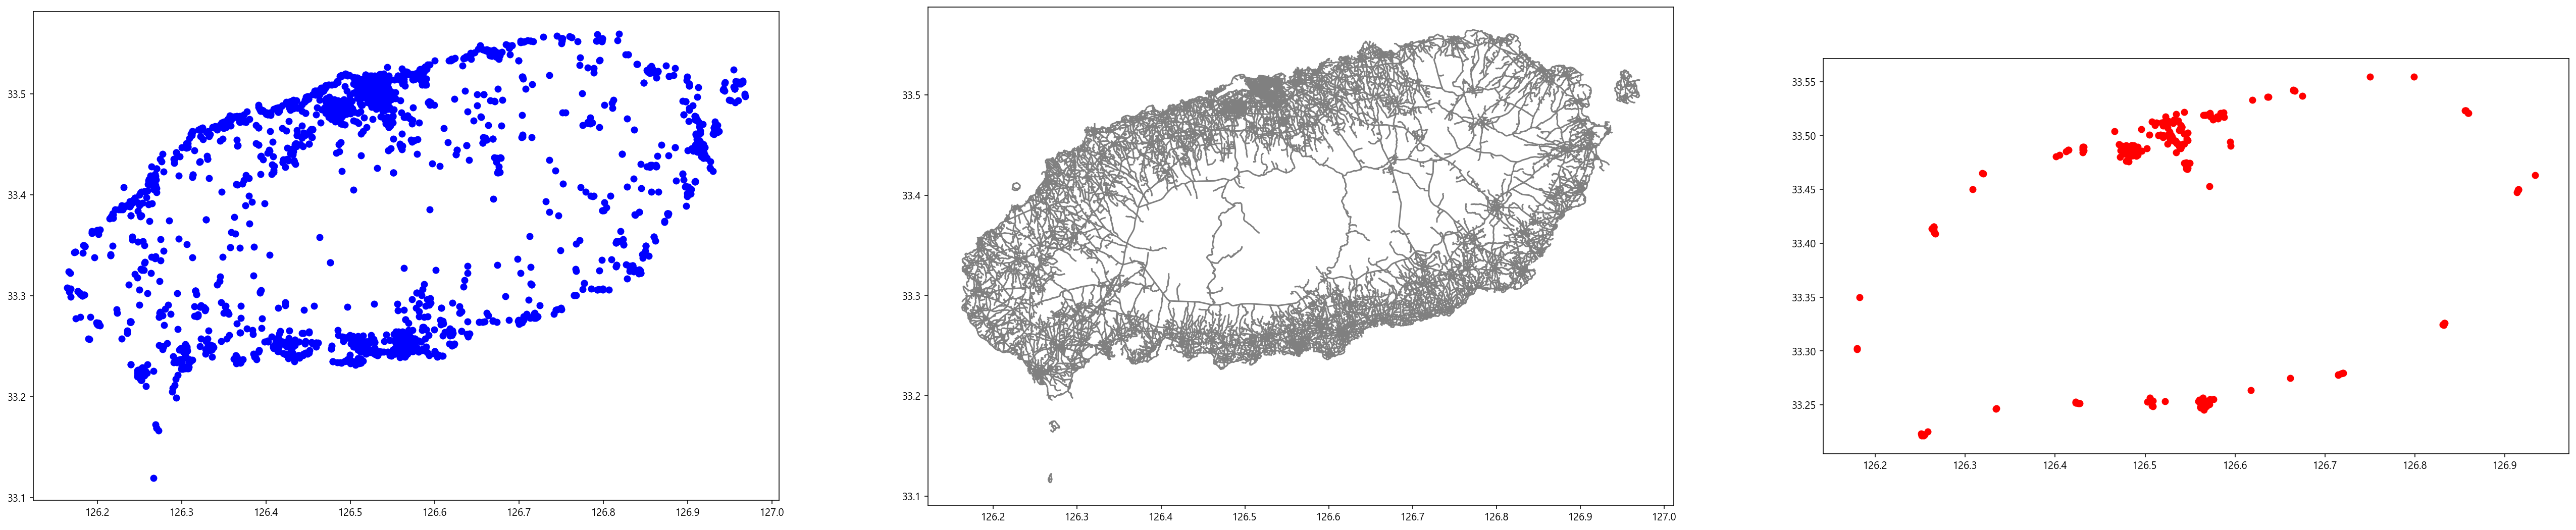

In [39]:
# fig,ax = plt.subplots(1,3,figsize=(45,15))
# gangnam_clients.plot(color='blue',ax=ax[0])
# gangnam_streets.plot(color='grey',ax=ax[1])
# gangnam_facility.plot(color='red',ax=ax[2])

### 세팅

In [40]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = gangnam_clients.shape[0], gangnam_facility.shape[0]

# candidate facilites to site
p_facilities = 8

# maximum coverage meters
max_coverage = 1000.0

# minimum coverage meters
min_coverage = 800.0

random_seeds = {"client": 3006, "facility": 1520}

# plot 제목
title = "Neighborhood X"

In [41]:
buff = 20
streets_buffer = get_buffer(gangnam_streets, buff=buff)

In [42]:
streets = gangnam_streets
#구분자 삽입
clients = gangnam_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]
#구분자 삽입
facilities = gangnam_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head(2))
display(facilities.head())

,EMD_KOR_NM,type,소재지,경도,위도,geometry,dv
0,연동,emer,제주특별자치도 제주시 도령로 65,126.484920,33.490266,POINT (126.48492 33.49027),x[0]
1,아라일동,emer,제주특별자치도 제주시 아란13길 15,126.545201,33.467209,POINT (126.54520 33.46721),x[1]


,EMD_KOR_NM,사업장명,도로명전체주소,X,Y,geometry,dv
0,연동,낙산약국,"제주특별자치도 제주시 도령로 87, 현대오피스텔 1층 106,107호 (연동)",126.487275,33.490869,POINT (126.48728 33.49087),y[0]
1,법환동,월드컵약국,"제주특별자치도 서귀포시 일주동로 9213, GS25 1층 6호 (법환동)",126.508491,33.248712,POINT (126.50849 33.24871),y[1]
2,삼양이동,삼양약국,"제주특별자치도 제주시 일주동로 366, 1층 (삼양이동)",126.584080,33.520884,POINT (126.58408 33.52088),y[2]
3,노형동,천지약국,"제주특별자치도 제주시 1100로 3347, 1층 (노형동)",126.479606,33.484837,POINT (126.47961 33.48484),y[3]
4,도남동,해모로약국,"제주특별자치도 제주시 연삼로 305, 101호 (도남동)",126.525167,33.492385,POINT (126.52517 33.49239),y[4]


In [43]:
add_to_plot = {"streets": gangnam_streets}
plotter(plot_aux=add_to_plot, title=title)

ValueError: Image size of 277390802x401260573 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x720 with 1 Axes>

In [ ]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
}

plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60,figsize=(10,10))

### 모델링

In [50]:
gangnam_streets.columns
gangnam_streets2 = gangnam_streets.drop(['ALWNC_DE', 'ALWNC_RESN', 'BSI_INT', 'ENG_RN', 'MVMN_DE', 'MVMN_RESN',
       'MVM_RES_CD', 'NTFC_DE', 'OPERT_DE', 'RBP_CN', 'RDS_DPN_SE',
       'RDS_MAN_NO', 'REP_CN', 'RN', 'RN_CD', 'ROAD_BT', 'ROAD_LT',
       'ROA_CLS_SE', 'SIG_CD', 'WDR_RD_CD'], axis=1)

In [98]:
x, y = gangnam_streets2[:13]['geometry'][0].coords.xy

In [116]:
gangnam_streets2[:14]

,geometry
0,"LINESTRING (126.25420 33.29289, 126.25418 33.2..."
1,"LINESTRING (126.26934 33.31728, 126.26941 33.3..."
2,"LINESTRING (126.24694 33.28947, 126.24697 33.2..."
3,"LINESTRING (126.26134 33.31170, 126.26133 33.3..."
4,"LINESTRING (126.24888 33.28993, 126.24886 33.2..."
5,"LINESTRING (126.25155 33.29107, 126.25146 33.2..."
6,"LINESTRING (126.25732 33.29504, 126.25735 33.2..."
7,"LINESTRING (126.26809 33.31668, 126.26812 33.3..."
8,"LINESTRING (126.26664 33.31584, 126.26700 33.3..."
9,"LINESTRING (126.23943 33.29209, 126.23944 33.2..."


In [115]:
# 네트워크 불러오기
ntw = spaghetti.Network(in_data=gangnam_streets2[:14])

IndexError: tuple index out of range

In [79]:
ntw.snapobservations(clients, "clients", attribute=True)

In [80]:
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

In [81]:
ntw.snapobservations(facilities, "facilities", attribute=True)

In [82]:
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [83]:
# Cost Matrix 계산 시간 소요
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3,:3]

array([[ 0., inf,  0.],
       [ 0., inf,  0.],
       [ 0., inf,  0.]])

#### mclp

In [85]:
clients

,EMD_KOR_NM,type,소재지,경도,위도,geometry,dv
0,연동,emer,제주특별자치도 제주시 도령로 65,126.484920,33.490266,POINT (126.48492 33.49027),x[0]
1,아라일동,emer,제주특별자치도 제주시 아란13길 15,126.545201,33.467209,POINT (126.54520 33.46721),x[1]
2,이도이동,emer,제주특별자치도 제주시 연신로 52,126.546239,33.496287,POINT (126.54624 33.49629),x[2]
3,동홍동,emer,제주특별자치도 서귀포시 장수로 47,126.562949,33.255981,POINT (126.56295 33.25598),x[3]
4,이호이동,emer,제주특별자치도 제주시 월랑로 91,126.470481,33.492321,POINT (126.47048 33.49232),x[4]
...,...,...,...,...,...,...,...
3076,화북일동,wifi,제주시 화북일동 11-8,126.573761,33.519675,POINT (126.57376 33.51967),x[3063]
3077,화북일동,wifi,제주시 화북일동 9-2,126.576347,33.519826,POINT (126.57635 33.51983),x[3064]
3078,화북일동,wifi,제주시 화북일동 14-1,126.576666,33.517935,POINT (126.57667 33.51794),x[3065]
3079,회수동,wifi,서귀포시 회수동 788-2,126.442481,33.263100,POINT (126.44248 33.26310),x[3066]


In [84]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=1000
)
clients, facilities = add_results(mclp, clients, facilities)

KeyError: 'weights'

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=2000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=1, s=3000
)
clients, facilities = add_results(mclp, clients, facilities)

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])